## Looking for the best ratio between labeled and unlabeled images in Self-training with Noisy Student
### Author: Yu Huang(yh3019)
This code is to visualize the evaluation metrics of models, which are trained with different ratios of unlabeled data to labeled data.

In [4]:
from __future__ import print_function

import os
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings 
warnings.simplefilter(action='ignore')

In [5]:
# !pip install opencv-python
# !pip install efficientnet
# !pip install imgaug

In [6]:
keras.__version__, tf.__version__

('2.2.4-tf', '1.13.1')

In [7]:
def preprocessing_y(y_train1):
    # convert class vectors to binary class matrices
    y_train1 = y_train1.reshape(y_train1.shape[0],)

    # In original dataset, Digit '1' has label 1, '9' has label 9 and '0' has label 10.
    # Now we change it to: Digit '1' has label 1, '9' has label 9 and '0' has label 0.
    y_train1[y_train1==10] = 0

    # one hot encoding
    y_train1    = keras.utils.to_categorical(y_train1, num_classes, dtype='uint8')
    
    return y_train1

def pesodu_label_generator(model_teacher, x_unlabel1):
    teacher_model = load_model("./models/"+model_teacher+".hdf5",custom_objects={"f1_m": f1_m})
    
    # preprocess unlabeled x 
    x_unlabel1 = x_unlabel1.astype('float32')
    x_unlabel1 = x_unlabel1/255.
    
    # Predict psuedo labels
    y_proba1 = teacher_model.predict(x_unlabel1)
    # y_proba1 = teacher_model.predict(aug_test.flow(x_unlabel1)) # steps = len(x_unlabel1)
    y_unlabel1 = np.argmax(y_proba1, axis=1)
    y_unlabel1 = preprocessing_y(y_unlabel1)
    
    return teacher_model, y_unlabel1, y_proba1

# Here we use F1-score and categorical_accuracy as evaluation metrics
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [13]:
# x_test = np.load('./predictions/x_test.npy')
num_label = 5000
num_classes = 10
class_labels = ['0','1','2','3','4','5','6','7','8','9']
epochs = 20

In [16]:
x_test = np.load('./predictions/x_test.npy') # load
y_test = np.load('./predictions/y_test.npy') # load
y_R1_stu2 = np.load('./predictions/y_student2_5000i_R1_20e.npy')
y_R2_stu2 = np.load('./predictions/y_student2_5000i_R2_20e.npy')
y_R3_stu2 = np.load('./predictions/y_student2_5000i_R3_20e.npy')
y_R4_stu2 = np.load('./predictions/y_student2_5000i_R4_20e.npy')

In [25]:
# predictions! If you have y_Rx_studx already, you do not need to run below
if y_R4_stu2.any() != None:
    print('Predictions loaded.')
else:
    model_name = [
                  'studentmodel2_R1_5000i_SVHN_20e_drop05',
                  'studentmodel2_R2_5000i_SVHN_20e_drop05',
                  'studentmodel2_R3_5000i_SVHN_20e_drop05',
                  'studentmodel2_R4_5000i_SVHN_20e_drop05'
                 ]  

    Ratio = [
             'R1', 
             'R2', 
             'R3', 
             'R4'
            ] 

    for mod, R in zip(model_name, Ratio):
        print('Prediction for ', R, ' started.')
        model, y_pred, y_proba = pesodu_label_generator(mod, x_test)
        y_pred = y_pred.argmax(axis=-1)
        np.save('./predictions/y_pred_5000i_'+R+'_20e.npy', y_pred)
        print('Prediction for ', R, ' finished.')

Predictions loaded.


In [19]:
y_R4_stu2 = y_R4_stu2.argmax(axis=-1)  # this file is a one hot encoded 2d array

In [26]:
f1 = []
ba = []
acc = []

model = [1, 2, 3, 4]
model_name = ['R=1', 'R=2', 'R=3', 'R=4']

for i in [y_R1_stu2, y_R2_stu2, y_R3_stu2, y_R4_stu2]:
    f1.append(f1_score(y_test, i, labels=None, average='macro'))
    ba.append(balanced_accuracy_score(y_test, i))
    acc.append(accuracy_score(y_test, i))

In [94]:
print('F1 balanced accuracy and accuracy of Student2 on Test Data for R=1,2,3,4: \n',
      np.around(f1,3),'\n', 
      np.around(ba,3),'\n', 
      np.around(acc,3))

F1 balanced accuracy and accuracy of Student2 on Test Data for R=1,2,3,4: 
 [0.804 0.808 0.824 0.803] 
 [0.799 0.799 0.813 0.795] 
 [0.826 0.826 0.844 0.827]


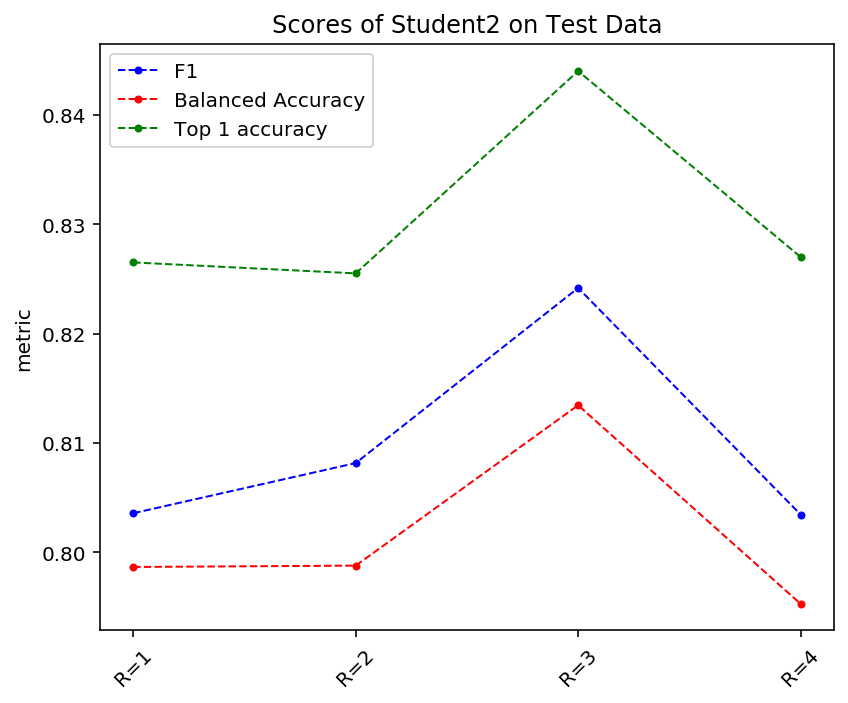

In [95]:
fig, ax = plt.subplots(figsize=(6,5),ncols=1)

ax.plot(model, f1, marker = 'o', c = 'b', linestyle='dashed', linewidth=1, markersize=3, label='F1')
ax.plot(model, ba, marker = 'o', c = 'r', linestyle='dashed', linewidth=1, markersize=3, label='Balanced Accuracy')
ax.plot(model, acc, marker = 'o', c = 'g', linestyle='dashed', linewidth=1, markersize=3, label='Top 1 accuracy')

ax.set_xlabel('')
ax.set_ylabel('metric')
ax.set_title('Scores of Student2 on Test Data')
ax.set_xticks(model)
ax.set_xticklabels(model_name, rotation=45)
ax.legend()

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/F1_ba_acc_studentmodel2_R1234_5000i_SVHN_20e_drop05.png')

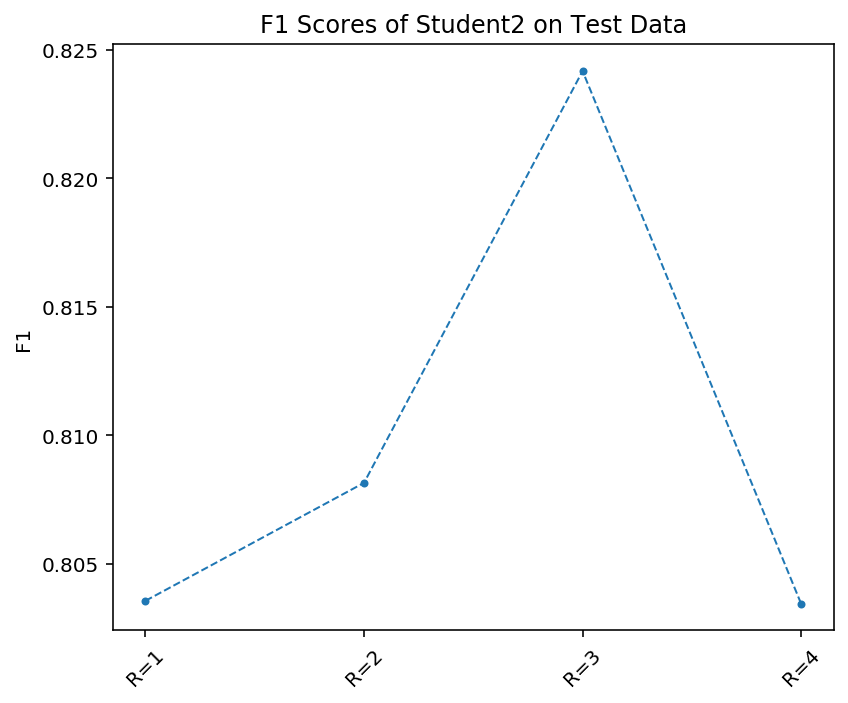

In [69]:
fig, ax = plt.subplots(figsize=(6,5),ncols=1)

ax.plot(model, f1, marker = 'o', linestyle='dashed', linewidth=1, markersize=3,

ax.set_xlabel('')
ax.set_ylabel('F1')
ax.set_title('F1 Scores of Student2 on Test Data')
ax.set_xticks(model)
ax.set_xticklabels(model_name, rotation=45)

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/F1_studentmodel2_R123_5000i_SVHN_20e_drop05.png')

In [81]:
# fig, axes = plt.subplots(figsize=(8,4),ncols=2)
def plot_confusion_matrix_n(cm, classes, cmap=plt.cm.Blues, save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, axes = plt.subplots(figsize=(12,12), nrows=len(cm)//2, ncols=2)
    
    k = 0
    b = 0
    tick_marks = np.arange(len(classes))
    
    for r, c in zip(range(len(cm)),cm):
        if b > 1:
            k += 1
            b = 0
        im = axes[k,b].imshow(c, interpolation='nearest', cmap=cmap)
        axes[k,b].set_title('R='+str(r+1))
        fig.colorbar(im, ax=axes[k,b], shrink=0.75)

        thresh = c.max() / 2.
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                axes[k,b].text(j, i, c[i, j],horizontalalignment="center", fontsize=8,
                             color="white" if c[i, j] > thresh else "black")

        axes[k,b].set_xticks(tick_marks)
        axes[k,b].set_xticklabels(classes, rotation=45)
        axes[k,b].set_yticks(tick_marks)
        axes[k,b].set_yticklabels(classes, rotation=45)
        axes[k,b].set_ylabel('True label')
        axes[k,b].set_xlabel('Predicted label')
        
        b += 1
        
        
#    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    fig.suptitle('')
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_test_'+save_path+'.png')

    plt.show()

In [82]:
cnf_matrix1 = confusion_matrix(y_test, y_R1_stu2, normalize='true')
cnf_matrix2 = confusion_matrix(y_test, y_R2_stu2, normalize='true')
cnf_matrix3 = confusion_matrix(y_test, y_R3_stu2, normalize='true')
cnf_matrix4 = confusion_matrix(y_test, y_R4_stu2, normalize='true')

cnf_matrix1 = np.around(cnf_matrix1,decimals=2)
cnf_matrix2 = np.around(cnf_matrix2,decimals=2)
cnf_matrix3 = np.around(cnf_matrix3,decimals=2)
cnf_matrix4 = np.around(cnf_matrix4,decimals=2)
    
cm = [cnf_matrix1, cnf_matrix2, cnf_matrix3, cnf_matrix4]

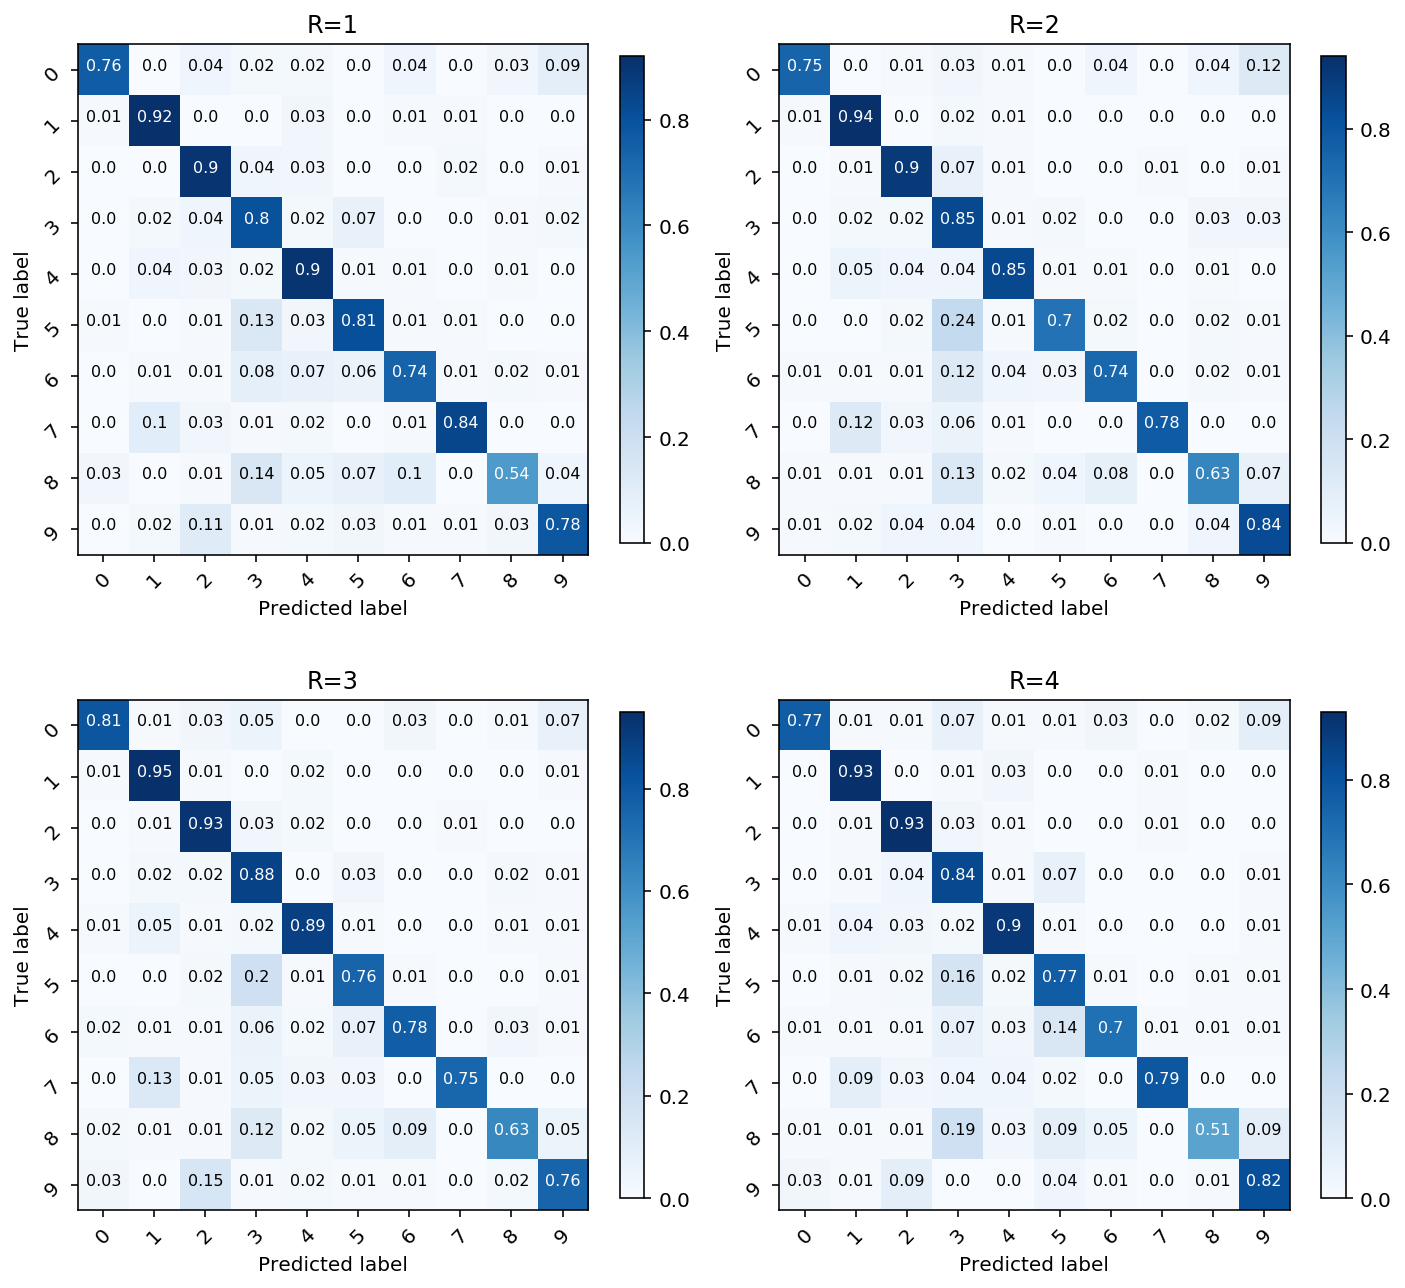

In [83]:
cm_plt = plot_confusion_matrix_n(cm, class_labels, cmap=plt.cm.Blues, 
                                 save_path='confusion_matrix_R1234_student2_5000i_drop05')

In [27]:
def plot_training(history):
    acc = history['categorical_accuracy']
    val_acc = history['val_categorical_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    f1 = history['f1_m']
    val_f1 = history['val_f1_m']
    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(12,4),ncols=3)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()
    axes[0].set_ylabel('metric')
    axes[0].set_xlabel('epoch number')

    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')
    axes[1].set_xlabel('epoch number')

    axes[2].plot(epochs, f1, 'b')
    axes[2].plot(epochs, val_f1, 'r')
    axes[2].set_title('Training and validation F1 score')
    axes[2].set_xlabel('epoch number')

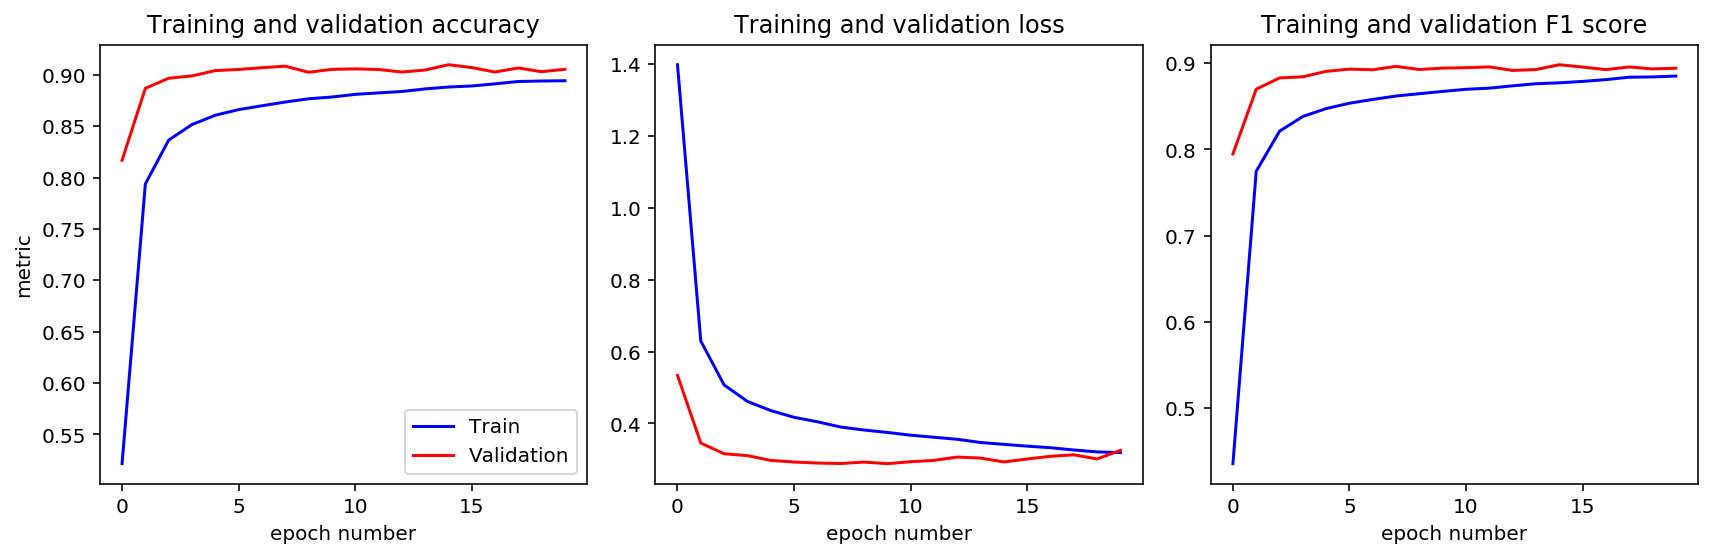

In [28]:
with open(r"./models/studentmodel2_R4_5000i_SVHN_20e_drop05.pckl", "rb") as input_file:
    H_student2 = pickle.load(input_file)
    
plot_training(H_student2)

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
plt.savefig('./Figures/history_studentmodel2_R4_5000i_SVHN_20e_drop05.png')